In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [32]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,
)

5
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


2023-04-28 21:24:03.420567: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


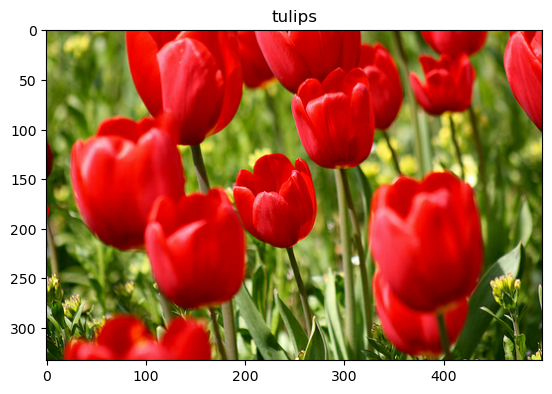

In [33]:
#check class
num_classes = metadata.features['label'].num_classes
print(num_classes)
get_label_name = metadata.features['label'].int2str
print([get_label_name(n) for n in range(5)])

image,label = next(iter(train_ds)) #iter 로 iterable한 객채로 변환, next로 첫번째 요소 추출
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [34]:
#사이즈 증강
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

MIN MAX pixel values :  0.0 1.0


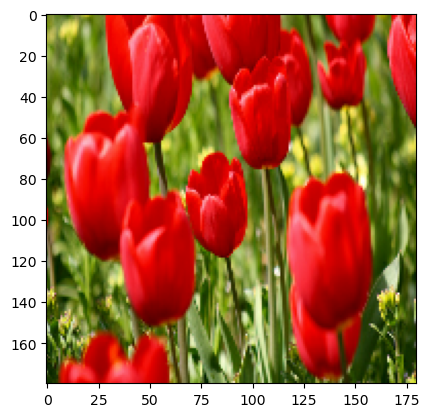

In [35]:
result = resize_and_rescale(image)
_ = plt.imshow(result)
print("MIN MAX pixel values : ",result.numpy().min(),result.numpy().max())

In [36]:
#데이터 회전과 관련된 증강
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [39]:
#expand_dims의 역할
print(image.shape)
image = tf.expand_dims(image,0)
print(image.shape)

(333, 500, 3)
(1, 333, 500, 3)


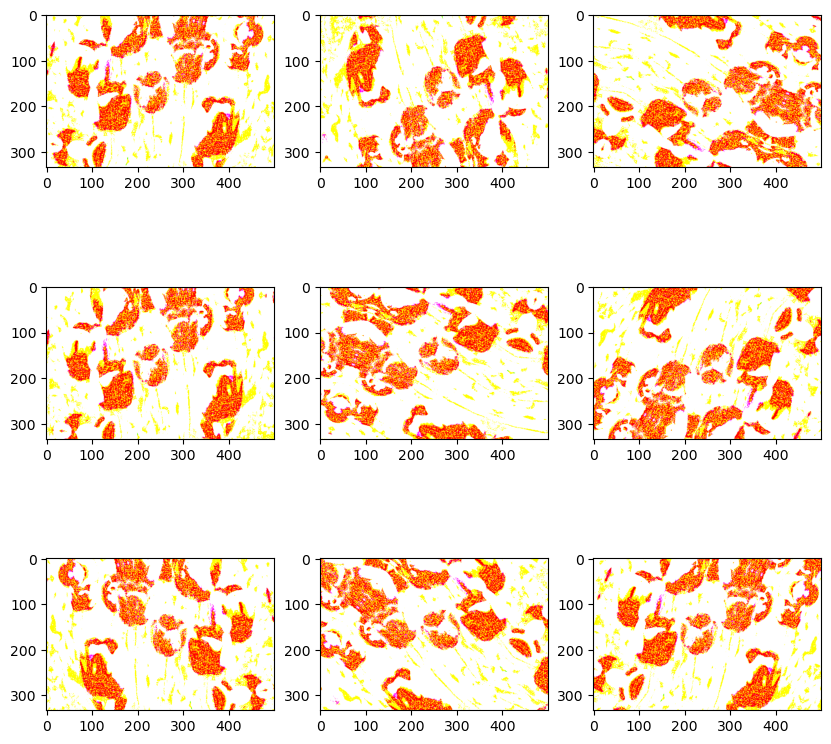

In [45]:
plt.figure(figsize=(10,10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_image[0])

### 1. 증강을 모델에 구성할 수 있다. 
- GPU 사용할 수 있어 유리
- model.fit호출에서만 증강

In [ ]:
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16,3,padding='smae',activation='relu'),
    layers.MaxPooling2D,
    #Rest of model
])

### 2. 다른 방식

In [ ]:
aug_ds = train_ds.map(lambda x,y : (resize_and_rescale(x,training=True),y))

In [47]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # resize and rescale all datasets
    ds = ds.map(lambda x,y : (resize_and_rescale(x),y),
                num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(1000)

    # batch all datasets
    ds = ds.batch(batch_size)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x,y : (data_augmentation(x,training=True),y),
                    num_parallel_calls=AUTOTUNE)
    # Use buffered prefecting on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds,shuffle=True,augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### 모델 구성

In [55]:
model = tf.keras.Sequential([
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes)
])


In [60]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [62]:
epochs = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
92/92 [==============================] - ETA: 0s - loss: 1.5857 - accuracy: 0.2766WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x1784865e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
92/92 [==============================] - 13s 104ms/step - loss: 1.5857 - accuracy: 0.2766 - val_loss: 1.5907 - val_accuracy: 0.2480
Epoch 2/5
92/92 [==============================] - 10s 98ms/step - loss: 1.5664 - accuracy: 0.2916 - val_loss: 1.5979 - val_accuracy: 0.2752
Epoch 3/5
92/92 [==============================] - 9s 95ms/step - loss: 1.5552 - accuracy: 0.2980 - val_loss: 1.6772 - val_accuracy: 0.1689
Epoch 4/5
92/92 [==============================] - 9s 89ms/step - loss: 1.5497 - accuracy: 0.3018 - val_loss: 1.7173 - val_accuracy: 0.1662
Epoch 5/5
92/92 [==============================] - 11s 118ms/step - loss: 1.5450 - accuracy: 0.3069 - val_loss: 1.7231 - val_accuracy: 0.1771


In [64]:
loss,acc = model.evaluate(test_ds)
print('Acc: ',acc)

12/12 [==============================] - 1s 41ms/step - loss: 1.7705 - accuracy: 0.1826
Acc:  0.18256130814552307


In [66]:
#정해진 확률값 기준으로 선별하여 이미지를 반전
def random_invert_img(x,p=0.5):
    if tf.random.uniform([]) < p:
        #이미지 반전
        x = (255-x)
    else:
        x
    return x
#
def random_invert(factor=0.5):
    return layers.Lambda(lambda x : random_invert_img(x,factor))

#random_invert 함수는 random_invert_img 함수를 람다 레이어에 적용하여 생성.
random_invert = random_invert()


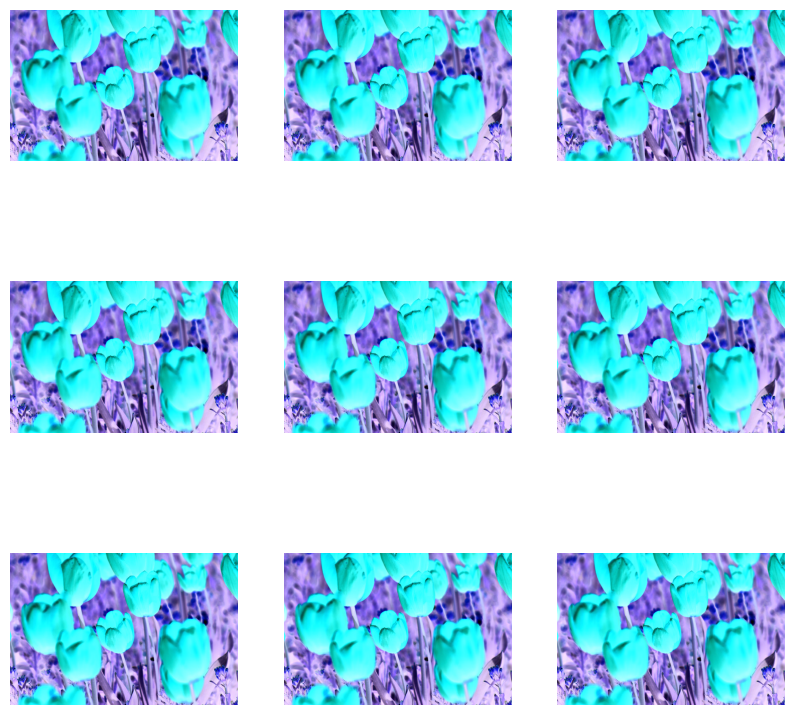

In [69]:
plt.figure(figsize=(10,10))
for i in range(9):
    augmented_image = random_invert(image)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_image[0].numpy().astype('uint8'))
    plt.axis('off')